#CP422 Assignment 2

## Loading Data

In [87]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("TaxiDataAnalysis") \
    .getOrCreate()
# Read the CSV file into a Spark DataFrame
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("yellow_tripdata_2015-01.csv")

# Create a temporary view for SQL queries
df.createOrReplaceTempView("yellow_taxi_data")


## Q1: Outlier Detection

### Task 1: Write a SQL query to find trips with fare amounts over $1000.

In [88]:
# SQL query to find trips with fare amounts over $1000
query = """
SELECT *
FROM yellow_taxi_data
WHERE fare_amount > 1000
"""

# Run the query
result_df = spark.sql(query)

# Show the results
result_df.show()

+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       2| 2015-01-02 20:06:34|  2015-01-02 20:23:33|              1|          0.4|-74.01433563232422|40.711856842041016|         1|    

### Task 2: Write another query to find trips with zero or negative fare amounts.

In [89]:
# SQL query to find trips with zero or negative fare amounts
query = """
SELECT *
FROM yellow_taxi_data
WHERE fare_amount <= 0
"""

# Run the query
result_df = spark.sql(query)

# Show the results
result_df.show()

+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       1| 2015-01-28 20:22:19|  2015-01-28 20:23:19|              2|          4.8|-74.03569030761719|40.743648529052734|         5|    

## Q2: Correlation Analysis

###Task 1.1: Write SQL queries to calculate the correlation between for fare_amount and trip_distance.

In [90]:
query = """
SELECT corr(fare_amount, trip_distance) AS fare_trip_distance_corr
FROM yellow_taxi_data
"""

# Run the query
result_df = spark.sql(query)

# Show the results
result_df.show()


+-----------------------+
|fare_trip_distance_corr|
+-----------------------+
|   4.422117955836895E-4|
+-----------------------+



### Task 1.2: Write SQL queries to calculate the correlation between total_amount and trip_distance.

In [91]:
query="""
SELECT corr(total_amount, trip_distance) AS total_trip_distance_corr
FROM yellow_taxi_data
"""
# Run the query
result_df = spark.sql(query)

# Show the results
result_df.show()

+------------------------+
|total_trip_distance_corr|
+------------------------+
|    3.339064563073854...|
+------------------------+



## Task 2: Analysis of Correlations

Correlation between fare_amount and trip_distance:
- A positive correlation coefficient close to 1 indicates a strong positive linear relationship, suggesting that as the trip distance increases, the fare amount also increases proportionally.

Correlation between total_amount and trip_distance:
- This correlation measures how the total amount (including fare and additional charges) relates to trip distance. A strong positive correlation implies that longer trips tend to have higher total charges.



## Q3: Trip Duration Prediction

### Task 1: Calculate the trip duration in minutes for each trip.


In [92]:
from pyspark.sql.functions import unix_timestamp

# Add a new column 'trip_duration_minutes' to the DataFrame
df_with_duration = df.withColumn(
    "trip_duration_minutes",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60
)

# Create a temporary view with the new column
df_with_duration.createOrReplaceTempView("yellow_taxi_with_duration")


### Task 2: Write a SQL query to find the average trip duration for trips with different passenger counts.

In [93]:




query = """
SELECT passenger_count, AVG(trip_duration_minutes) AS average_trip_duration
FROM yellow_taxi_with_duration
GROUP BY passenger_count
ORDER BY passenger_count
"""

# Run the query
result_df = spark.sql(query)

# Show the results
result_df.show()


+---------------+---------------------+
|passenger_count|average_trip_duration|
+---------------+---------------------+
|              0|   12.558855039350089|
|              1|   14.246676076779718|
|              2|   13.842955421433144|
|              3|   14.025823263687862|
|              4|   13.840397849632195|
|              5|   14.517415328235217|
|              6|   14.051230948944927|
|              7|    8.837037037037037|
|              8|    5.345000000000001|
|              9|   15.793939393939395|
+---------------+---------------------+



## Q4: Trip Clustering

## Task 1: Use SQL to categorize trips into distance bins (e.g., <1 mile, 1-2 miles, 2-5 miles, >5 miles).

In [94]:
query="""
-- SQL query to categorize trips into distance bins
SELECT *,
       CASE
           WHEN trip_distance < 1 THEN '<1 mile'
           WHEN trip_distance >= 1 AND trip_distance < 2 THEN '1-2 miles'
           WHEN trip_distance >= 2 AND trip_distance <= 5 THEN '2-5 miles'
           ELSE '>5 miles'
       END AS distance_bin
FROM yellow_taxi_data
"""

# Run the query
result_df = spark.sql(query)

# Show the results
result_df.show()

+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|distance_bin|
+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+
|       2| 2015-01-15 19:05:39|  2015-01-15 19:23:42|              1|         1.59|  -73.99389648

## Task 2: Write a SQL query to calculate the average fare amount for each distance bin.

In [95]:
from pyspark.sql.functions import when

# Create the distance_bin column based on the conditions
df_with_bins = df.withColumn(
    "distance_bin",
    when(df.distance <= 1, "<1 mile")
    .when((df.distance > 1) & (df.distance <= 2), "1-2 miles")
    .when((df.distance > 2) & (df.distance <= 5), "2-5 miles")
    .when(df.distance > 5, ">5 miles")
    .otherwise("Unknown")
)

# Create a temporary view with the new column
df_with_bins.createOrReplaceTempView("yellow_taxi_with_bins")

# Now run the SQL query without the CASE expression in the ORDER BY clause
query = """
SELECT distance_bin, AVG(fare_amount) AS average_fare_amount
FROM yellow_taxi_with_bins
GROUP BY distance_bin
ORDER BY distance_bin
"""

# Run the query
result_df = spark.sql(query)

# Show the results
result_df.show()

AttributeError: 'DataFrame' object has no attribute 'distance'

## Visualization:
We can visualize the average fare amount per distance bin using a bar chart.

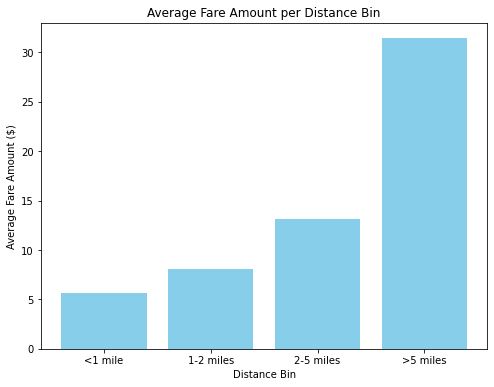

In [0]:
# Convert the query result to a Pandas DataFrame for plotting
average_fare_by_bin = spark.sql("""
    SELECT distance_bin, AVG(fare_amount) AS average_fare_amount
    FROM yellow_taxi_with_bins
    GROUP BY distance_bin
""").toPandas()

import pandas as pd
import matplotlib.pyplot as plt

# Ensure the bins are in the correct order
bin_order = ['<1 mile', '1-2 miles', '2-5 miles', '>5 miles']
average_fare_by_bin['distance_bin'] = pd.Categorical(average_fare_by_bin['distance_bin'], categories=bin_order, ordered=True)
average_fare_by_bin = average_fare_by_bin.sort_values('distance_bin')

# Plot the average fare amount per distance bin
plt.figure(figsize=(8,6))
plt.bar(average_fare_by_bin['distance_bin'], average_fare_by_bin['average_fare_amount'], color='skyblue')
plt.xlabel('Distance Bin')
plt.ylabel('Average Fare Amount ($)')
plt.title('Average Fare Amount per Distance Bin')
plt.show()


## Q5: 

In [96]:
# SQL query to create distance bins and calculate average fare for each bin
query = """
SELECT 
    CASE 
        WHEN trip_distance < 1 THEN '<1 mile'
        WHEN trip_distance >= 1 AND trip_distance < 2 THEN '1-2 miles'
        WHEN trip_distance >= 2 AND trip_distance < 5 THEN '2-5 miles'
        WHEN trip_distance >= 5 AND trip_distance < 10 THEN '5-10 miles'
        ELSE '>10 miles'
    END AS distance_bin,
    AVG(fare_amount) AS average_fare
FROM yellow_taxi_data
GROUP BY distance_bin
ORDER BY 
    CASE 
        WHEN distance_bin = '<1 mile' THEN 1
        WHEN distance_bin = '1-2 miles' THEN 2
        WHEN distance_bin = '2-5 miles' THEN 3
        WHEN distance_bin = '5-10 miles' THEN 4
        WHEN distance_bin = '>10 miles' THEN 5
    END
"""

# Execute the query
distance_fare_bins = spark.sql(query)

# Show the result
distance_fare_bins.show()

+------------+------------------+
|distance_bin|      average_fare|
+------------+------------------+
|     <1 mile| 5.672120578999713|
|   1-2 miles|  8.04041196316821|
|   2-5 miles|13.087495501926742|
|  5-10 miles|23.568011860162635|
|   >10 miles| 44.72180584584484|
+------------+------------------+



## Visualization

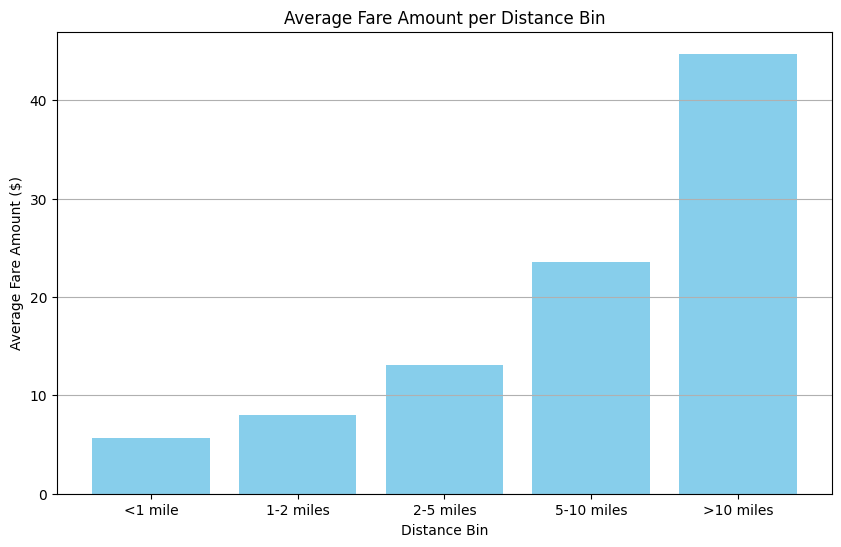

In [97]:
# Convert the Spark DataFrame to Pandas for plotting
distance_fare_bins_df = distance_fare_bins.toPandas()

# Import necessary libraries for plotting
import matplotlib.pyplot as plt

# Plot the average fare per distance bin
plt.figure(figsize=(10, 6))
plt.bar(distance_fare_bins_df['distance_bin'], distance_fare_bins_df['average_fare'], color='skyblue')
plt.xlabel('Distance Bin')
plt.ylabel('Average Fare Amount ($)')
plt.title('Average Fare Amount per Distance Bin')
plt.grid(axis='y')
plt.show()

In [ ]:
# Convert the Spark DataFrame to Pandas for plotting
distance_fare_bins_df = distance_fare_bins.toPandas()

# Import necessary libraries for plotting
import matplotlib.pyplot as plt

# Plot the average fare per distance bin
plt.figure(figsize=(10, 6))
plt.bar(distance_fare_bins_df['distance_bin'], distance_fare_bins_df['average_fare'], color='skyblue')
plt.xlabel('Distance Bin')
plt.ylabel('Average Fare Amount ($)')
plt.title('Average Fare Amount per Distance Bin')
plt.grid(axis='y')
plt.show()

## Q10: Payment Type Fare Comparison

In [ ]:
# SQL query to calculate average fare amount for each payment type
query = """
SELECT payment_type, AVG(fare_amount) AS average_fare_amount
FROM yellow_taxi_data
GROUP BY payment_type
"""

# Execute the query
result_df = spark.sql(query)

# Show the result
result_df.show()

+------------+-------------------+
|payment_type|average_fare_amount|
+------------+-------------------+
|           1|  12.50128976774208|
|           3| 10.396839148892102|
|           4|   9.71586034079519|
|           2| 10.948657421477954|
|           5|                3.0|
+------------+-------------------+



## Visualization:

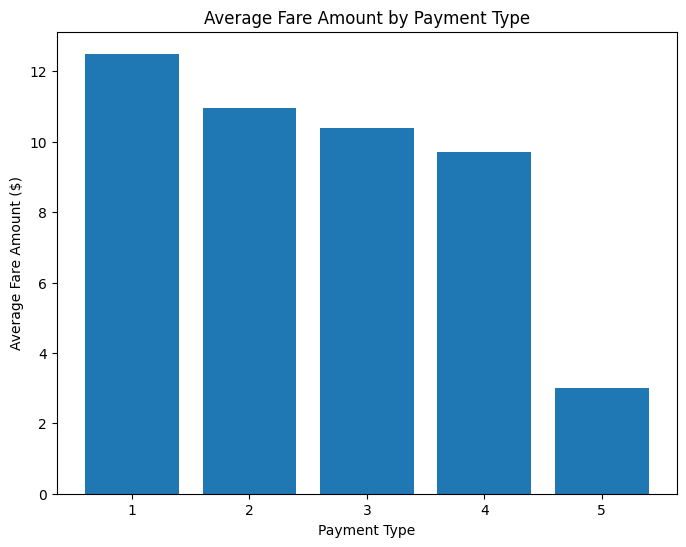

In [ ]:
# Convert the Spark DataFrame to a Pandas DataFrame for plotting
average_fare_by_payment_type = result_df.toPandas()

# Import necessary libraries for plotting
import matplotlib.pyplot as plt

# Plot the average fare by payment type
plt.figure(figsize=(8, 6))
plt.bar(average_fare_by_payment_type['payment_type'], average_fare_by_payment_type['average_fare_amount'])
plt.xlabel('Payment Type')
plt.ylabel('Average Fare Amount ($)')
plt.title('Average Fare Amount by Payment Type')
plt.show()

## Q11: : Time Series Analysis of Trips

In [ ]:
# SQL query to count trips per day
query = """
SELECT DATE(tpep_pickup_datetime) AS trip_date, COUNT(*) AS trip_count
FROM yellow_taxi_data
GROUP BY trip_date
ORDER BY trip_date
"""

# Execute the query
daily_trip_counts = spark.sql(query)

# Show the result
daily_trip_counts.show()

+----------+----------+
| trip_date|trip_count|
+----------+----------+
|2015-01-01|    382014|
|2015-01-02|    345296|
|2015-01-03|    406769|
|2015-01-04|    328848|
|2015-01-05|    363454|
|2015-01-06|    384324|
|2015-01-07|    429653|
|2015-01-08|    450920|
|2015-01-09|    447947|
|2015-01-10|    515540|
|2015-01-11|    419629|
|2015-01-12|    396367|
|2015-01-13|    448517|
|2015-01-14|    442656|
|2015-01-15|    451186|
|2015-01-16|    478124|
|2015-01-17|    476827|
|2015-01-18|    427042|
|2015-01-19|    342795|
|2015-01-20|    405581|
+----------+----------+
only showing top 20 rows



## Visualization:

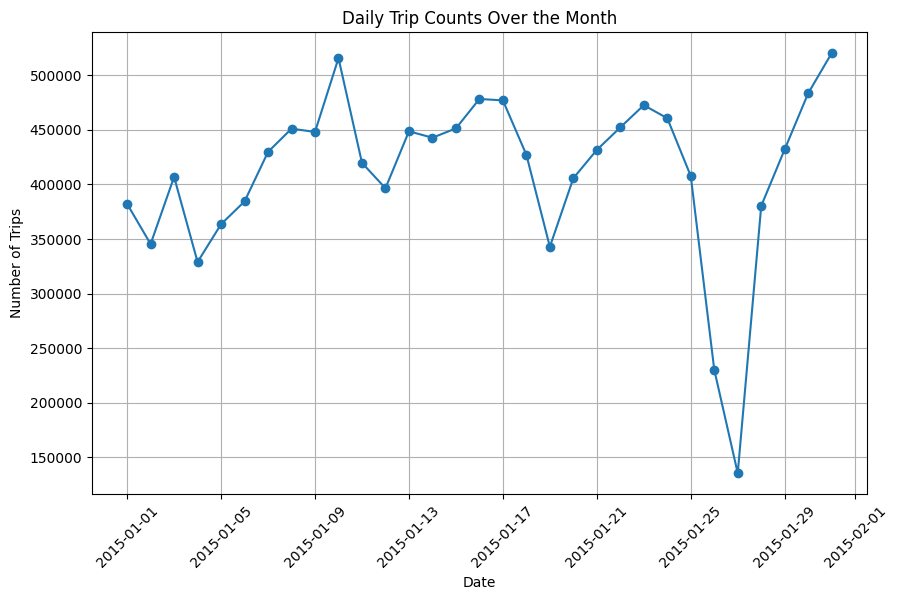

In [ ]:
# Convert the result to a Pandas DataFrame
import pandas as pd
daily_trip_counts_df = daily_trip_counts.toPandas()

# Import necessary libraries for plotting
import matplotlib.pyplot as plt

# Convert 'trip_date' to datetime format for accurate plotting
daily_trip_counts_df['trip_date'] = pd.to_datetime(daily_trip_counts_df['trip_date'])

# Plot the daily trip counts
plt.figure(figsize=(10, 6))
plt.plot(daily_trip_counts_df['trip_date'], daily_trip_counts_df['trip_count'], marker='o')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.title('Daily Trip Counts Over the Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Q12: Location Analysis

In [ ]:
# SQL query to find the top 10 pickup locations
pickup_query = """
SELECT pickup_longitude, pickup_latitude, COUNT(*) AS trip_count
FROM yellow_taxi_data
GROUP BY pickup_longitude, pickup_latitude
ORDER BY trip_count DESC
LIMIT 10
"""

# Execute the query
top_pickup_locations = spark.sql(pickup_query)

# Show the result
top_pickup_locations.show()

24/11/07 13:53:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 13:53:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 13:53:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 13:53:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 13:53:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 13:53:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 13:53:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 13:53:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 13:53:05 WARN RowBasedKeyValueBatch: Calling spill() on

+------------------+------------------+----------+
|  pickup_longitude|   pickup_latitude|trip_count|
+------------------+------------------+----------+
|               0.0|               0.0|    243478|
|-73.94863891601562| 40.74489974975586|      1043|
| -74.1863021850586| 40.69314193725586|       729|
| -73.9867172241211|  40.7222900390625|       429|
|-73.91512298583984| 40.74357604980469|       306|
|-74.00314331054688| 40.72767639160156|       233|
|-73.92151641845703|40.691463470458984|       153|
|-73.98845672607422|40.731502532958984|       147|
|-73.97827911376953|  40.6429443359375|       121|
|-73.94208526611328|40.754417419433594|       108|
+------------------+------------------+----------+



24/11/07 13:53:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 13:53:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 13:53:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 13:53:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 13:53:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 13:53:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 13:53:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 13:53:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/07 13:53:15 WARN RowBasedKeyValueBatch: Calling spill() on

+------------------+------------------+----------+
| dropoff_longitude|  dropoff_latitude|trip_count|
+------------------+------------------+----------+
|               0.0|               0.0|    235318|
|-73.94863891601562| 40.74489974975586|      1043|
| -74.1863021850586| 40.69314193725586|       729|
| -73.9867172241211|  40.7222900390625|       428|
|-73.91512298583984| 40.74357604980469|       322|
|-74.00314331054688| 40.72767639160156|       233|
|-73.98845672607422|40.731502532958984|       155|
|-73.92151641845703|40.691463470458984|       153|
|-73.97827911376953|  40.6429443359375|       121|
|-73.94208526611328|40.754417419433594|       108|
+------------------+------------------+----------+



In [ ]:
dropoff_query = """
SELECT dropoff_longitude, dropoff_latitude, COUNT(*) AS trip_count
FROM yellow_taxi_data
GROUP BY dropoff_longitude, dropoff_latitude
ORDER BY trip_count DESC
LIMIT 10
"""

# Execute the query
top_dropoff_locations = spark.sql(dropoff_query)

# Show the result
top_dropoff_locations.show()

## Visualization

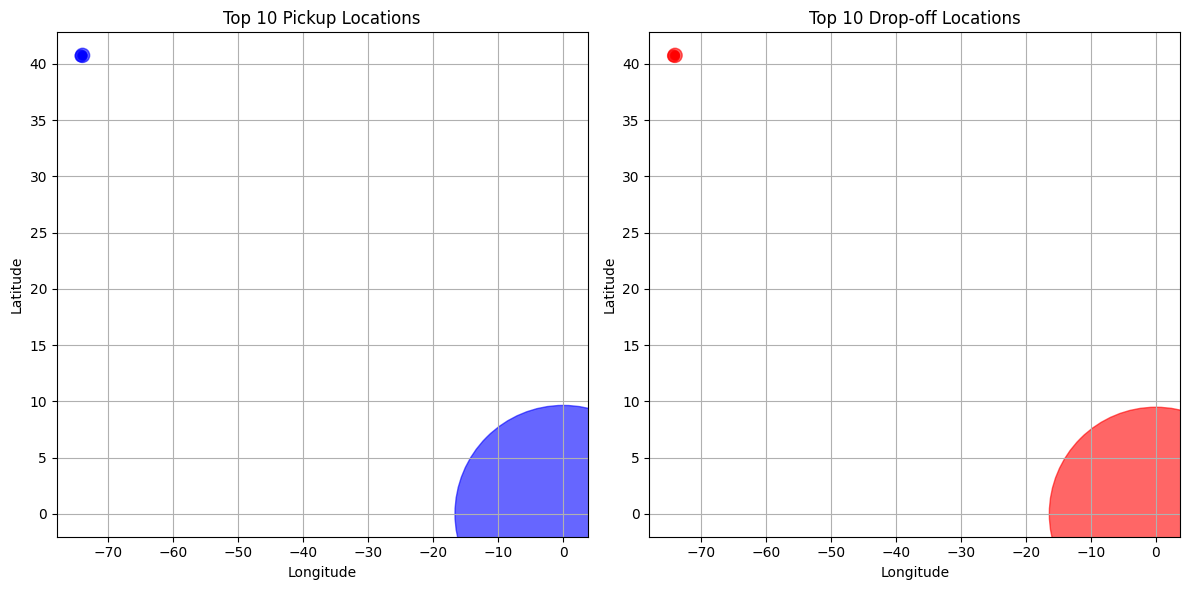

In [ ]:
import matplotlib.pyplot as plt

# Convert the Spark DataFrames to Pandas DataFrames
pickup_df = top_pickup_locations.toPandas()
dropoff_df = top_dropoff_locations.toPandas()

# Plot settings
plt.figure(figsize=(12, 6))

# Scatter plot for top pickup locations
plt.subplot(1, 2, 1)
plt.scatter(pickup_df['pickup_longitude'], pickup_df['pickup_latitude'], 
            s=pickup_df['trip_count'] * 0.1, c='blue', alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Top 10 Pickup Locations')
plt.grid(True)

# Scatter plot for top drop-off locations
plt.subplot(1, 2, 2)
plt.scatter(dropoff_df['dropoff_longitude'], dropoff_df['dropoff_latitude'], 
            s=dropoff_df['trip_count'] * 0.1, c='red', alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Top 10 Drop-off Locations')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

## Q13: Fare Amount Distribution Analysis

In [ ]:
# SQL query to get summary statistics for fare amounts
summary_query = """
SELECT 
    MIN(fare_amount) AS min_fare,
    MAX(fare_amount) AS max_fare,
    AVG(fare_amount) AS avg_fare,
    PERCENTILE_APPROX(fare_amount, 0.5) AS median_fare,
    STDDEV(fare_amount) AS stddev_fare
FROM yellow_taxi_data
"""

# Execute the query
summary_stats = spark.sql(summary_query)

# Show the result
summary_stats.show()

+--------+--------+------------------+-----------+------------------+
|min_fare|max_fare|          avg_fare|median_fare|       stddev_fare|
+--------+--------+------------------+-----------+------------------+
|  -450.0|  4008.0|11.905659425776989|        9.0|10.302537135952232|
+--------+--------+------------------+-----------+------------------+



## Visualization:

24/11/07 14:03:04 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


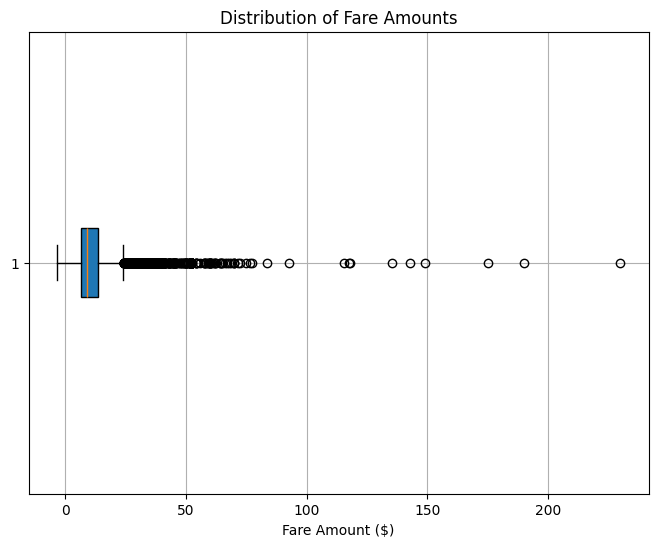

In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session (if not already initialized)
spark = SparkSession.builder \
    .appName("FareAmountAnalysis") \
    .getOrCreate()

# Execute the query with a LIMIT to reduce data size for testing
limited_fare_amount_df = spark.sql("SELECT fare_amount FROM yellow_taxi_data LIMIT 10000").toPandas()

# Import necessary libraries for plotting
import matplotlib.pyplot as plt

# Plot a box plot for fare amounts
plt.figure(figsize=(8, 6))
plt.boxplot(limited_fare_amount_df['fare_amount'], vert=False, patch_artist=True)
plt.xlabel('Fare Amount ($)')
plt.title('Distribution of Fare Amounts')
plt.grid(True)
plt.show()